In [1]:
# Import libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## load preprocess and convert image to blob

In [2]:
# load the image to detect
img_to_detect = cv2.imread('images/scene3.jpg')

In [3]:
img_to_detect.shape

(500, 960, 3)

In [4]:
# get height and width of image
img_height = img_to_detect.shape[0]
img_width = img_to_detect.shape[1]

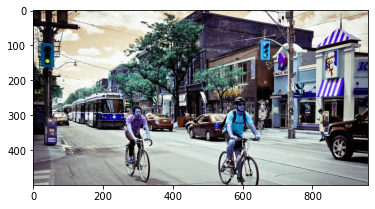

In [5]:
plt.imshow(img_to_detect)

In [6]:
# convert to blob to pass into model
# recommended scale factor is 0.003922 = 1/255 and width, height of blob is 320,320
# accepted sizes are 320*320 416*416, 609*609. More size means more accuracy but less spead
img_blob = cv2.dnn.blobFromImage(img_to_detect,0.003922,(416,416),swapRB=True, crop=False)

In [7]:
# Set of 80 class labels in alphabetical order (background + rest of 20 classes)

class_labels = ["person","bicycle","car","motorcycle","airplane","bus","train","truck","boat","trafficlight","firehydrant","stopsign","parkingmeter","bench","bird","cat","dog","horse","sheep","cow","elephant","bear","zebra","giraffe","backpack","umbrella","handbag","tie","suitcase","frisbee","skis","snowboard","sportsball","kite","baseballbat","baseballglove","skateboard","surfboard","tennisracket","bottle","wineglass","cup","fork","knife","spoon","bowl","banana","apple","sandwich","orange","broccoli","carrot","hotdog","pizza","donut","cake","chair","sofa","pottedplant","bed","diningtable","toilet","tvmonitor","laptop","mouse","remote","keyboard","cellphone","microwave","oven","toaster","sink","refrigerator","book","clock","vase","scissors","teddybear","hairdrier","toothbrush"]

## Load Pre-trained model and get prediction

In [8]:
# Loading pre-trained model from prototext and caffemodel files 
yolo_model = cv2.dnn.readNetFromDarknet('datasets/yolov4.cfg','datasets/yolov4.weights')

# Get all layers from yolo network
# Loop and find the last layer (output layer) of the yolo network
yolo_layers =yolo_model.getLayerNames()
yolo_output_layer = [yolo_layers[yolo_layer[0]-1] for yolo_layer in yolo_model.getUnconnectedOutLayers()]

In [9]:
# Input preprocessed blob into model and pass through the model
yolo_model.setInput(img_blob)

In [10]:
# obtain the detection predictions by the model using forward() method
obj_detection_layers = yolo_model.forward(yolo_output_layer)

In [11]:
# to fix multiple box overlapping issue using non-maximum supression (NMS)
############## NMS Change 1 ###############
# initialization for non-max suppression (NMS)
# declare list for [class id], [box center, width & height[], [confidences]
class_ids_list = []
boxes_list = []
confidences_list = []
############## NMS Change 1 END ###########

## Loop over detections, Get Class labels, Box co-ordinates

In [12]:
# loop over each of the layer outputs
for object_detection_layer in obj_detection_layers:
    # loop over the detections
    for object_detection in object_detection_layer:
        
        # obj_detections[1 to 4] => will have the bounding box co-ordinates
        # obj_detections[5] => will have scores for all objects within bounding box
        all_scores = object_detection[5:]
        predicted_class_id = np.argmax(all_scores)
        prediction_confidence = all_scores[predicted_class_id]
        
        # take only predictions with confidence more than 50%
        if prediction_confidence > 0.5:
            # get the predicted label
            predicted_class_label = class_labels[predicted_class_id]
            # obtain the bounding box co-ordinates for the actual image from resized image size
            bounding_box = object_detection[0:4] * np.array([img_width, img_height, img_width, img_height])
            (box_center_x_pt, box_center_y_pt, box_width, box_height) = bounding_box.astype("int")
            start_x_pt = int(box_center_x_pt - (box_width/2))
            start_y_pt = int(box_center_y_pt - (box_height/2))
            
            ############## NMS Change 2 ###############
            #save class id, start x, y, width & height, confidences in a list for nms processing
            #make sure to pass confidence as float and width and height as integers
            class_ids_list.append(predicted_class_id)
            confidences_list.append(float(prediction_confidence))
            boxes_list.append([start_x_pt, start_y_pt, int(box_width), int(box_height)])
            ############## NMS Change 2 END ###########
            
############## NMS Change 3 ###############
# Applying the NMS will return only the selected max value ids while suppressing the non maximum (weak) overlapping bounding boxes      
# Non-Maxima Suppression confidence set as 0.5 & max_suppression threhold for NMS as 0.4 (adjust and try for better perfomance)
max_value_ids = cv2.dnn.NMSBoxes(boxes_list, confidences_list, 0.5, 0.4)

# loop through the final set of detections remaining after NMS and draw bounding box and write text
for max_valueid in max_value_ids:
    max_class_id = max_valueid[0]
    box = boxes_list[max_class_id]
    start_x_pt = box[0]
    start_y_pt = box[1]
    box_width = box[2]
    box_height = box[3]
    
    #get the predicted class id and label
    predicted_class_id = class_ids_list[max_class_id]
    predicted_class_label = class_labels[predicted_class_id]
    prediction_confidence = confidences_list[max_class_id]
############## NMS Change 3 END ###########

    #obtain the bounding box end co-oridnates
    end_x_pt = start_x_pt + box_width
    end_y_pt = start_y_pt + box_height

    # Print the prediction in console
    predicted_class_label = "{}: {:.2f}%".format(class_labels[predicted_class_id],prediction_confidence*100)
    print("predicted object {}".format(predicted_class_label))

    # Draw rectangle and text in the image
    cv2.rectangle(img_to_detect, (start_x_pt,start_y_pt), (end_x_pt,end_y_pt), (0,0,255),2)
    cv2.putText(img_to_detect, predicted_class_label, (start_x_pt,start_y_pt-5), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0,255,0),1)
           
            

predicted object person: 99.59%
predicted object car: 99.56%
predicted object person: 98.82%
predicted object car: 98.62%
predicted object bicycle: 98.30%
predicted object bicycle: 97.12%
predicted object bus: 96.59%
predicted object car: 95.68%
predicted object trafficlight: 94.56%
predicted object car: 89.11%
predicted object person: 85.89%
predicted object trafficlight: 84.21%
predicted object person: 66.56%
predicted object backpack: 66.48%
predicted object person: 54.49%


In [13]:
# Show the output image
#plt.imshow(img_to_detect)

cv2.imshow("Detection Output", img_to_detect)
cv2.waitKey(0)
cv2.destroyAllWindows()